In [1]:
import os
import logging

#Set absl logging level to suppress warnings
logging.getLogger('absl').setLevel(logging.ERROR)

#Standard Data Packages
import pandas as pd
import numpy as np

#Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

#Scikit
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Other Packages
import joblib

## Load Datasets

In [2]:
#load dataset

train_set = pd.read_csv('../data/train_norm_set.csv')
val_set = pd.read_csv('../data/val_norm_set.csv')

In [3]:
#split into features & labels

features = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

X_train = train_set[features]
Y_train = train_set["Exited"]

X_val = val_set[features]
Y_val = val_set["Exited"]

In [4]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.470,0,0,0.472973,0.2,0.000000,0.333333,1,1,0.459140
1,0.512,0,1,0.081081,0.2,0.000000,0.000000,0,1,0.454370
2,0.566,1,1,0.351351,0.1,0.473928,0.000000,1,0,0.238851
3,0.504,1,1,0.297297,0.2,0.597701,0.333333,1,1,0.413466
4,0.590,0,1,0.175676,0.4,0.527510,0.000000,1,0,0.759450


## Random Forest Experiment 1

#### Fit and Evaluate on Train Data

Train set score: 0.9997576240229218
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91072
           1       1.00      1.00      1.00     24451

    accuracy                           1.00    115523
   macro avg       1.00      1.00      1.00    115523
weighted avg       1.00      1.00      1.00    115523



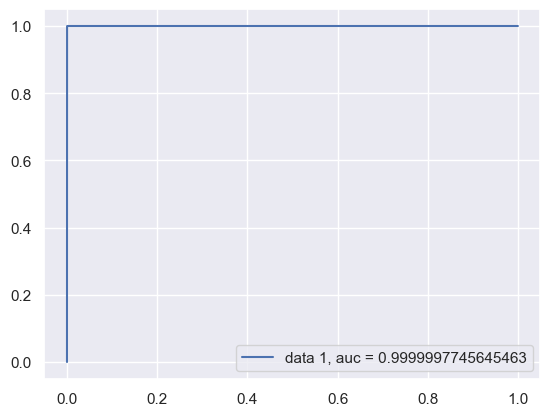

In [5]:
#define random forest model
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)

#fit model on train set
rf.fit(X_train, Y_train)

#model evaluations
print("Train set score: " + str(rf.score(X_train, Y_train)))

predict_train = rf.predict(X_train)

print(metrics.classification_report(Y_train, predict_train))

#ROC Curve and AUC
y_pred_proba = rf.predict_proba(X_train)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_train,  y_pred_proba)
auc = metrics.roc_auc_score(Y_train, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

plt.show()

#### Make Predictions and Evaluate on Validation Data

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39041
           1       0.74      0.54      0.63     10470

    accuracy                           0.86     49511
   macro avg       0.81      0.75      0.77     49511
weighted avg       0.85      0.86      0.85     49511



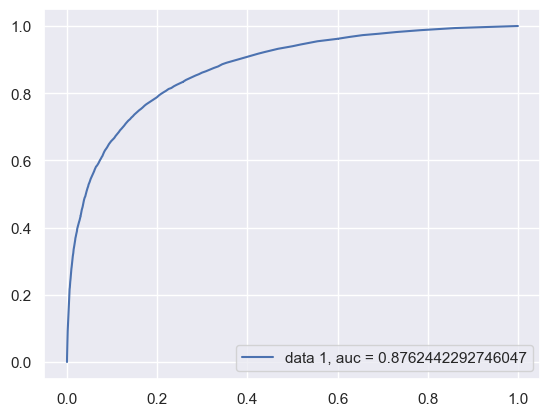

In [6]:
#make prediction on validation set
score_val = rf.score(X_val, Y_val)

predict_val = rf.predict(X_val)

#evaluate
print(metrics.classification_report(Y_val, predict_val))

y_pred_proba = rf.predict_proba(X_val)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_val,  y_pred_proba)
auc = metrics.roc_auc_score(Y_val, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

plt.show()

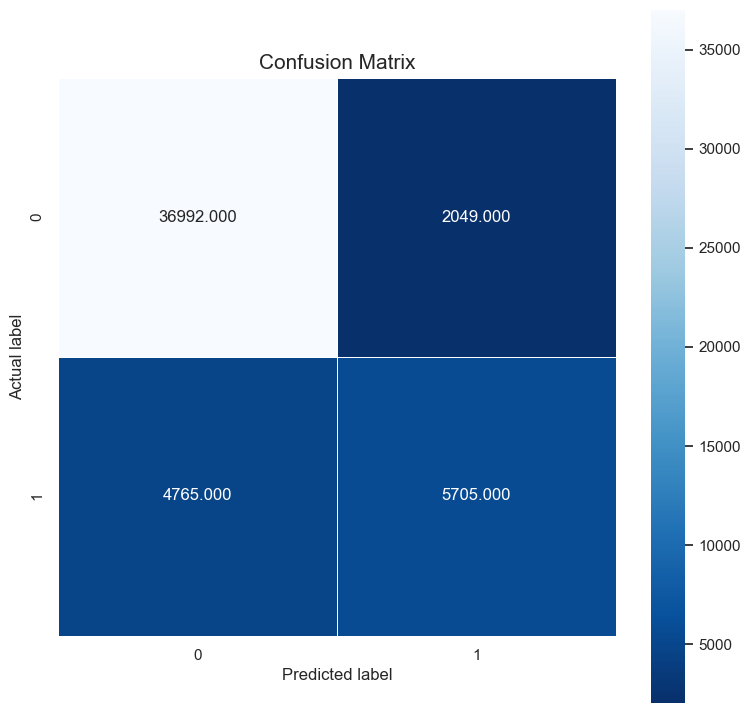

In [8]:
#plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

## Random Forest Cross Validation 1

#### Define parameters

In [9]:
param_grid = { 
    "n_estimators": [200, 500, 1000],
    "max_features": ["sqrt", "log2", None],
    "max_depth" : [8, 10, 15, 20, None],
    "criterion" :["gini", "entropy", "log_loss"]
}

#### Fit CV on Train Data

In [19]:
#create model object
rf_func = RandomForestClassifier(random_state = 42)

#create grid search model
rf_cv = GridSearchCV(estimator = rf_func, param_grid = param_grid, cv = 3, scoring = "f1", verbose = 1)
#fit on training set
rf_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [8, 10, 15, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [200, 500, 1000]},
             scoring='f1', verbose=1)

#### Best Parameters from CV

In [20]:
print(f"Best Score: {rf_cv.best_score_}, Best Param: {rf_cv.best_params_}")

Best Score: 0.6283457095874373, Best Param: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'n_estimators': 200}


## Random Forest Best Model (unbalanced)

#### Fit and Evaluate on Train Data

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     91072
           1       0.78      0.58      0.66     24451

    accuracy                           0.88    115523
   macro avg       0.84      0.77      0.79    115523
weighted avg       0.87      0.88      0.87    115523



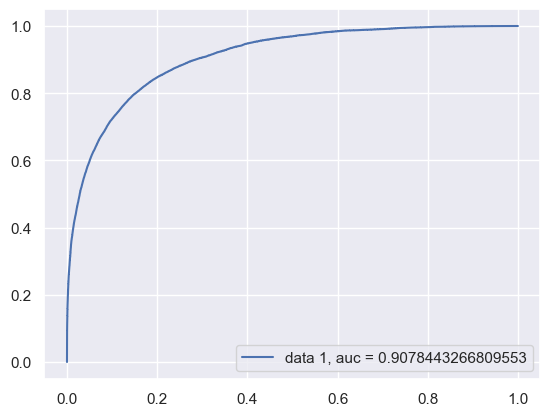

In [10]:
#build and fit model
rf_best_unbalanced = RandomForestClassifier(max_features = None, n_estimators = 200, max_depth = 10, criterion = "gini", random_state = 42)
rf_best_unbalanced.fit(X_train, Y_train)

predict_train = rf_best_unbalanced.predict(X_train)

print(metrics.classification_report(Y_train, predict_train))

#ROC Curve and AUC
y_pred_proba = rf_best_unbalanced.predict_proba(X_train)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_train,  y_pred_proba)
auc = metrics.roc_auc_score(Y_train, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

plt.show()

#### Make Predictions and Evaluate on Validation Data

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     39041
           1       0.74      0.56      0.64     10470

    accuracy                           0.87     49511
   macro avg       0.82      0.75      0.78     49511
weighted avg       0.86      0.87      0.86     49511



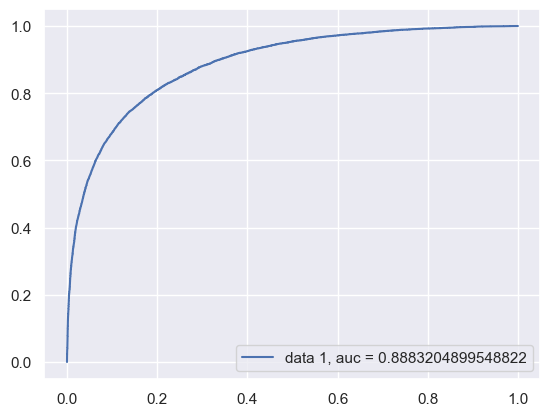

In [11]:
#make predictions
predict_val = rf_best_unbalanced.predict(X_val)

#evaluate
print(metrics.classification_report(Y_val, predict_val))

y_pred_proba = rf_best_unbalanced.predict_proba(X_val)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_val,  y_pred_proba)
auc = metrics.roc_auc_score(Y_val, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

plt.show()

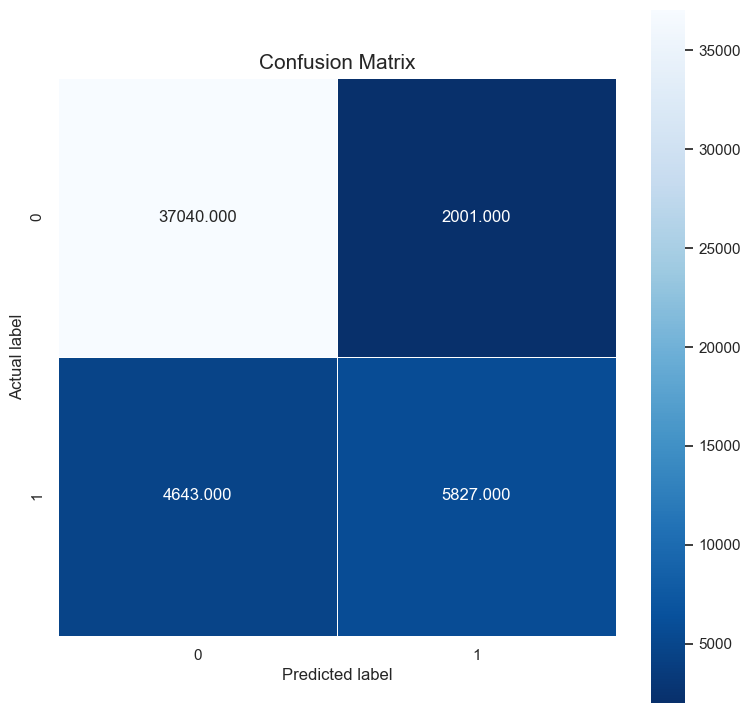

In [12]:
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

## Random Forest Cross Validation 2 (undersampled unbalanced dataset)

#### Load Data

In [13]:
train_norm_balanced = pd.read_csv('../data/train_norm_balanced.csv')

X_train_balanced = train_norm_balanced[features]
Y_train_balanced = train_norm_balanced["Exited"]

In [22]:
#create model object
rf_func = RandomForestClassifier(random_state = 42)

#create grid search model
rf_cv = GridSearchCV(estimator = rf_func, param_grid = param_grid, cv = 3, scoring = "f1", verbose = 1)
#fit on training set
rf_cv.fit(X_train_balanced, Y_train_balanced)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [8, 10, 15, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [200, 500, 1000]},
             scoring='f1', verbose=1)

#### Best Parameters from CV

In [23]:
print(f"Best Score: {rf_cv.best_score_}, Best Param: {rf_cv.best_params_}")

Best Score: 0.8039736931241421, Best Param: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}


## Random Forest Best Model (undersampled balanced dataset)

#### Load Undersampled Balanced Data

In [14]:
train_norm_balanced = pd.read_csv('../data/train_norm_balanced.csv')

X_train_balanced = train_norm_balanced[features]
Y_train_balanced = train_norm_balanced["Exited"]

#### Fit and Evaluate on Train Data

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     24451
           1       0.84      0.82      0.83     24451

    accuracy                           0.83     48902
   macro avg       0.83      0.83      0.83     48902
weighted avg       0.83      0.83      0.83     48902



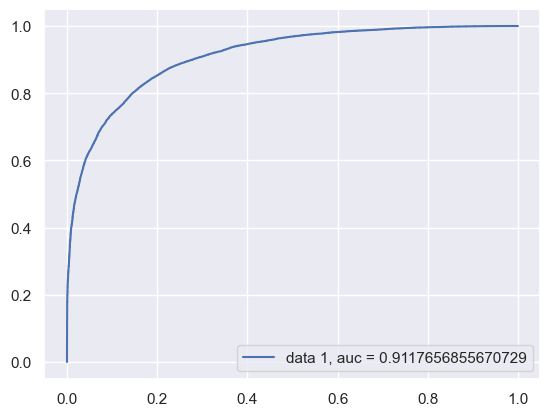

In [15]:
#build and fit model
rf_best_balanced = RandomForestClassifier(max_features = "sqrt", n_estimators = 1000, max_depth = 10, criterion = "entropy", random_state = 42)
rf_best_balanced.fit(X_train_balanced, Y_train_balanced)

predict_train = rf_best_balanced.predict(X_train_balanced)

print(metrics.classification_report(Y_train_balanced, predict_train))

#ROC Curve and AUC
y_pred_proba = rf_best_balanced.predict_proba(X_train_balanced)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_balanced,  y_pred_proba)
auc = metrics.roc_auc_score(Y_train_balanced, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

plt.show()

#### Make Predictions and Evaluate on Validation Data

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     39041
           1       0.53      0.80      0.64     10470

    accuracy                           0.81     49511
   macro avg       0.74      0.81      0.75     49511
weighted avg       0.85      0.81      0.82     49511



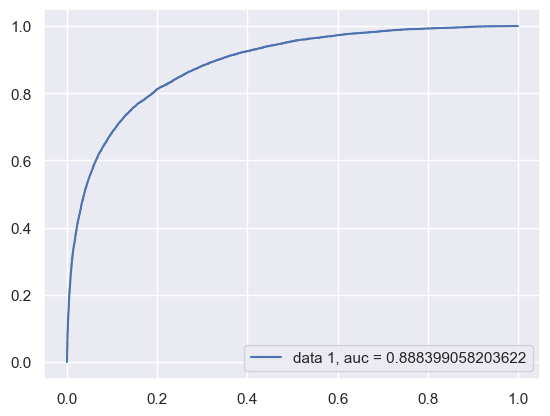

In [16]:
predict_val = rf_best_balanced.predict(X_val)

print(metrics.classification_report(Y_val, predict_val))

y_pred_proba = rf_best_balanced.predict_proba(X_val)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_val,  y_pred_proba)
auc = metrics.roc_auc_score(Y_val, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

plt.show()

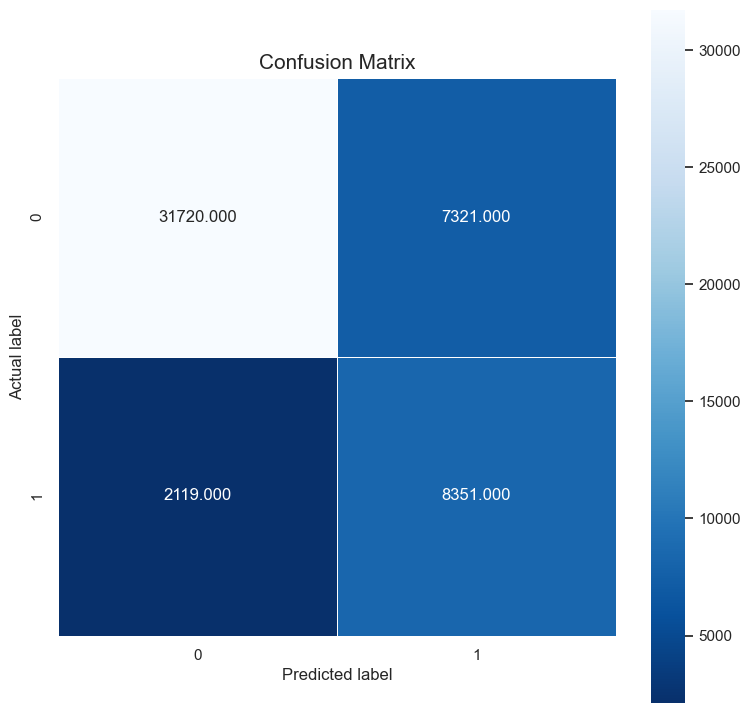

In [17]:
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

In [18]:
joblib.dump(rf_best_balanced, "../models/rf_best_balanced.joblib")
joblib.dump(rf_best_unbalanced, "../models/rf_best_unbalanced.joblib") 

['../models/rf_best_unbalanced.joblib']